# Train a StarNet Model

This notebook takes you through the steps of how to train a StarNet model (from our [original paper](https://arxiv.org/abs/1709.09182))
- Required Python packages: `numpy h5py pytorch torchsummary`

In [1]:
import os
import numpy as np
import h5py
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torchsummary import summary

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

model_dir = 'models/'
data_dir = 'data/'

model_filename =  os.path.join(model_dir,'starnet_cnn_1.pth.tar')
synth_data_file = os.path.join(data_dir, 'gaia_grid.h5')
label_keys = ['teff', 'feh', 'logg', 'alpha']

Using Torch version: 1.13.1+cu117
Using a cpu device


## Normalization

Collect the necessary information to normalize the input spectra as well as the target labels. During training, the spectra and labels will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units.

In [2]:
# Collect mean and std of the training data
with h5py.File(synth_data_file, "r") as f:
    
    labels_mean = [np.mean(f[k + ' train'][:]) for k in label_keys]
    labels_std = [np.std(f[k + ' train'][:]) for k in label_keys]
    spectra_mean = np.mean(f['spectra train'][:]) 
    spectra_std = np.mean(f['spectra train'][:])

## Dataloader

In [3]:
class SpectraDatasetSimple(torch.utils.data.Dataset):
    
    """
    Dataset loader for the spectral datasets.
    """

    def __init__(self, data_file, dataset, label_keys):
        
        self.data_file = data_file
        self.dataset = dataset.lower()
        self.label_keys = label_keys
        # Determine the number of pixels in each spectrum
        self.num_pixels = self.determine_num_pixels()
                        
    def __len__(self):
        with h5py.File(self.data_file, "r") as f:    
            num_spectra = len(f['spectra %s' % self.dataset])
        return num_spectra
    
    def determine_num_pixels(self):
        with h5py.File(self.data_file, "r") as f:    
            num_pixels = f['spectra %s' % self.dataset].shape[1]
        return num_pixels
    
    def __getitem__(self, idx):
        
        with h5py.File(self.data_file, "r") as f: 
                
            # Load spectrum
            spectrum = f['spectra %s' % self.dataset][idx]
            spectrum[spectrum<-1] = -1.
            spectrum = torch.from_numpy(spectrum.astype(np.float32))
            
            # Load target stellar labels
            data_keys = f.keys()
            labels = []
            for k in self.label_keys:
                data_key = k + ' %s' % self.dataset
                if data_key in data_keys:
                    labels.append(f[data_key][idx])
                else:
                    labels.append(np.nan)
            labels = torch.from_numpy(np.asarray(labels).astype(np.float32))
            
        # Return full spectrum and target labels
        return {'spectrum':spectrum,
                'labels':labels}
    
def batch_to_device(batch, device):
    '''Convert a batch of samples to the desired device.'''
    for k in batch.keys():
        if isinstance(batch[k], list):
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device)
        else:
            try:
                batch[k] = batch[k].to(device)
            except AttributeError:
                batch[k] = torch.tensor(batch[k]).to(device)
    return batch

In [4]:
batch_size = 16

# Training data
synth_train_dataset = SpectraDatasetSimple(synth_data_file, 
                                            dataset='train', 
                                            label_keys=['teff', 'feh', 'logg', 'alpha'])

synth_train_dataloader = torch.utils.data.DataLoader(synth_train_dataset,
                                                      batch_size=batch_size, 
                                                      shuffle=True, 
                                                      num_workers=1,
                                                      pin_memory=True)

# Validation data
synth_val_dataset = SpectraDatasetSimple(synth_data_file, 
                                         dataset='val', 
                                            label_keys=['teff', 'feh', 'logg', 'alpha'])

synth_val_dataloader = torch.utils.data.DataLoader(synth_val_dataset,
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=1,
                                                   pin_memory=True)

print('The training set consists of %i spectra.' % (len(synth_train_dataset)))
print('The validation set consists of %i spectra.' % (len(synth_val_dataset)))

The training set consists of 48373 spectra.
The validation set consists of 3000 spectra.


## Construct model

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

In [5]:
# Number of pixels per spectrum
num_pixels = synth_train_dataset.num_pixels

# Number of filters used in the convolutional layers
num_filters = [4, 16]

# Length of the filters in the convolutional layers
filter_length = 8

# Length of the maxpooling window 
pool_length = 4

# Number of nodes in each of the hidden fully connected layers
num_hidden = [256, 128]

# Number of output labels
num_labels = len(label_keys)

def compute_out_size(in_size, mod):
    """
    Compute output size of Module `mod` given an input with size `in_size`.
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

class StarNet(nn.Module):
    def __init__(self, num_pixels, num_filters, filter_length, 
                 pool_length, num_hidden, num_labels,
                 spectra_mean, spectra_std, labels_mean, labels_std):
        super().__init__()
        
        # Save distribution of training data
        self.spectra_mean = spectra_mean
        self.spectra_std = spectra_std
        self.labels_mean = torch.tensor(np.asarray(labels_mean).astype(np.float32)).to(device)
        self.labels_std = torch.tensor(np.asarray(labels_std).astype(np.float32)).to(device)
        
        # Convolutional and pooling layers
        self.conv1 = nn.Conv1d(1, num_filters[0], filter_length)
        self.conv2 = nn.Conv1d(num_filters[0], num_filters[1], filter_length)
        self.pool = nn.MaxPool1d(pool_length, pool_length)
        
        # Determine shape after pooling
        pool_output_shape = compute_out_size((1,num_pixels), 
                                             nn.Sequential(self.conv1, 
                                                           self.conv2, 
                                                           self.pool))
        
        # Fully connected layers
        self.fc1 = nn.Linear(pool_output_shape[0]*pool_output_shape[1], num_hidden[0])
        self.fc2 = nn.Linear(num_hidden[0], num_hidden[1])
        self.output = nn.Linear(num_hidden[1], num_labels)

    def normalize(self, data, data_mean, data_std):
        '''Normalize inputs to have zero-mean and unit-variance.'''
        return (data - data_mean) / data_std
    
    def denormalize(self, data, data_mean, data_std):
        '''Undo the normalization to put the data back in the original scale.'''
        return data * data_std + data_mean
        
    def forward(self, x, norm_in=True, denorm_out=False):
        
        if norm_in:
            # Normalize spectra to have zero-mean and unit variance
            x = self.normalize(x, self.spectra_mean, self.spectra_std)
        
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        
        if denorm_out:
            # Denormalize predictions to be on the original scale of the labels
            x = self.denormalize(x, self.labels_mean, self.labels_std)
            
        return x

model = StarNet(num_pixels, num_filters, filter_length, 
                pool_length, num_hidden, num_labels,
                spectra_mean, spectra_std, labels_mean, labels_std)
model = model.to(device)

summary(model, (num_pixels, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 4, 793]              36
├─Conv1d: 1-2                            [-1, 16, 786]             528
├─MaxPool1d: 1-3                         [-1, 16, 196]             --
├─Linear: 1-4                            [-1, 256]                 803,072
├─Linear: 1-5                            [-1, 128]                 32,896
├─Linear: 1-6                            [-1, 4]                   516
Total params: 837,048
Trainable params: 837,048
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 3.19
Estimated Total Size (MB): 3.32


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 4, 793]              36
├─Conv1d: 1-2                            [-1, 16, 786]             528
├─MaxPool1d: 1-3                         [-1, 16, 196]             --
├─Linear: 1-4                            [-1, 256]                 803,072
├─Linear: 1-5                            [-1, 128]                 32,896
├─Linear: 1-6                            [-1, 4]                   516
Total params: 837,048
Trainable params: 837,048
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 3.19
Estimated Total Size (MB): 3.32

## Define optimizer

* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function

In [6]:
# Total number of batch iterations for training
total_batch_iters = int(1e4)

# Initial learning rate for optimization algorithm
learning_rate = 0.001

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             learning_rate,
                             weight_decay=0)

## Train model

In [7]:
cur_iter = 0
verbose_iters = 1000
losses = defaultdict(list)
running_loss = []
# Continuously loop over the training set
while cur_iter < (total_batch_iters):
    for train_batch in synth_train_dataloader:
        
        # Set parameters to trainable
        model.train()
        
        # Switch to GPU if available
        train_batch = batch_to_device(train_batch, device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward propagation
        label_preds = model(train_batch['spectrum'], 
                            norm_in=True, 
                            denorm_out=False)
        
        # Compute mean-squared-error loss between predictions and normalized targets
        loss = torch.nn.MSELoss()(label_preds, 
                                  model.normalize(train_batch['labels'], 
                                                  model.labels_mean,
                                                  model.labels_std))
        
        # Back-propagation
        loss.backward()
        
        # Weight updates
        optimizer.step()
        
        # Save losses to take find average later
        running_loss.append(float(loss))
        
        cur_iter += 1
        
        # Display progress
        if cur_iter % verbose_iters == 0:
            
            # Take average of training losses
            train_loss = np.mean(running_loss)
            running_loss = []
            
            # Set parameters to not trainable
            model.eval()
            
            # Evaluate on validation set and display losses
            with torch.no_grad():
                for val_batch in synth_val_dataloader:

                    # Switch to GPU if available
                    val_batch = batch_to_device(val_batch, device)

                    # Forward propagation
                    label_preds = model(val_batch['spectrum'], 
                                        norm_in=True, 
                                        denorm_out=False)

                    # Compute mean-squared-error loss between predictions and normalized targets
                    loss = torch.nn.MSELoss()(label_preds, 
                                              model.normalize(val_batch['labels'], 
                                                              model.labels_mean,
                                                              model.labels_std))
                    # Save losses to take find average later
                    running_loss.append(float(loss))
                    
            # Average validation loss
            val_loss = np.mean(running_loss)
            running_loss = []
            
            losses['train_loss'].append(train_loss)
            losses['val_loss'].append(val_loss)

            # Print progress
            print('[Iter %i, %0.0f%%]' % (cur_iter, cur_iter/total_batch_iters*100))
            print('\tTrain Loss: %0.4f' % (train_loss))
            print('\tVal Loss: %0.4f' % (val_loss))
            
            # Save model
            torch.save({'optimizer' : optimizer.state_dict(),
                        'model' : model.state_dict(), 
                        'batch_iters' : cur_iter,
                        'losses' : losses},
                       model_filename)
            
        if cur_iter >= total_batch_iters:
            # Save model
            torch.save({'optimizer' : optimizer.state_dict(),
                        'model' : model.state_dict(), 
                        'batch_iters' : cur_iter,
                        'losses' : losses},
                       model_filename)
            print('Finished Training')
            break

[Iter 1000, 10%]
	Train Loss: 0.3071
	Val Loss: 0.1447
[Iter 2000, 20%]
	Train Loss: 0.0910
	Val Loss: 0.0923
[Iter 3000, 30%]
	Train Loss: 0.0626
	Val Loss: 0.0613
[Iter 4000, 40%]
	Train Loss: 0.0500
	Val Loss: 0.0596
[Iter 5000, 50%]
	Train Loss: 0.0451
	Val Loss: 0.0461
[Iter 6000, 60%]
	Train Loss: 0.0396
	Val Loss: 0.0369
[Iter 7000, 70%]
	Train Loss: 0.0363
	Val Loss: 0.0352
[Iter 8000, 80%]
	Train Loss: 0.0338
	Val Loss: 0.0319
[Iter 9000, 90%]
	Train Loss: 0.0309
	Val Loss: 0.0401
[Iter 10000, 100%]
	Train Loss: 0.0296
	Val Loss: 0.0296
Finished Training


## Load model

This code allows you to load a saved model to either continue training or apply the network on new data.

If you are continuing to train the model, it is important that you `load_state_dict` for both the model itself **and** the optimizer.

In [8]:
# Load model info
checkpoint = torch.load(model_filename, 
                        map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])
cur_iter = checkpoint['batch_iters']

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer'])

# Load model weights
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

## Plot training progress

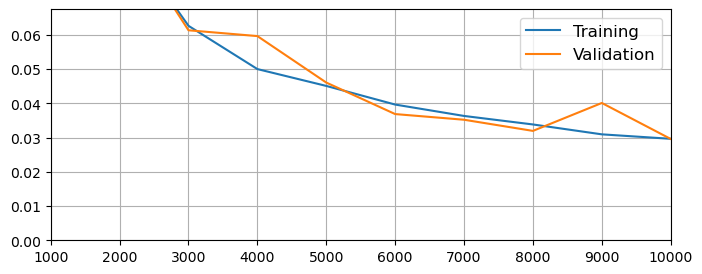

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))

# Determine iteration of checkpoint
batch_iters = np.linspace(cur_iter/len(losses['train_loss']), 
                          cur_iter, len(losses['train_loss']))

# Plot training and validation progress
plt.plot(batch_iters, losses['train_loss'], label='Training')
plt.plot(batch_iters, losses['val_loss'], label='Validation')
plt.xlim(batch_iters[0], batch_iters[-1])
plt.ylim(0, 1.1*losses['val_loss'][2])
plt.legend(fontsize=12)
plt.grid()
plt.show()

## Inference time

We can apply our trained model to the validation set and see how our predictions compare against the ground truth labels.

In [10]:
# Set parameters to not trainable
model.eval()

# Estimate labels of the validation spectra
tgt_labels = []
pred_labels = []
with torch.no_grad():
    for val_batch in synth_val_dataloader:
        
        # Switch to GPU if available
        val_batch = batch_to_device(val_batch, device)

        # Forward propagation (and denormalize outputs)
        label_preds = model(val_batch['spectrum'], 
                            norm_in=True, 
                            denorm_out=True)
        
        # Save batch data for comparisons
        pred_labels.append(label_preds.cpu().data.numpy())
        tgt_labels.append(val_batch['labels'].cpu().data.numpy())
        
pred_labels = np.concatenate(pred_labels)
tgt_labels = np.concatenate(tgt_labels)

Because the ground truth labels for our synthetic spectra are on a grid, we can create box plots of the residuals rather than your typical residual plot. This function below creates a fancy box plot that gives a nice visualization the distribution (called a violin plot).

In [11]:
def plot_resid_violinplot(label_keys, tgt_stellar_labels, pred_stellar_labels, 
                          y_lims = [1000, 1, 1, 1, 10], savename=None):
    
    fig, axes = plt.subplots(len(label_keys), 1, figsize=(12, len(label_keys)*2.7))
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
    
    # Iterate through labels
    for i, ax in enumerate(axes):
        label_key = label_keys[i]
        
        # Make axis label pretty
        if label_key=='teff':
            label_key = 'T$_{\mathrm{eff}}$ [K]'
        if label_key=='feh':
            label_key = '[Fe/H]'
        if label_key=='logg':
            label_key = '$\log{g}$'
        if label_key=='alpha':
            label_key = r'[$\alpha$/H]'
        if label_key=='vrad':
            label_key = r'$v_{\mathrm{rad}}$ [km/s]'
            
        # Calculate residual
        diff = pred_stellar_labels[:,i] - tgt_stellar_labels[:,i]
            
        # Determine boxplot info
        box_positions = []
        box_data = []
        for tgt_val in np.unique(tgt_stellar_labels[:,i]):
            indices = np.where(tgt_stellar_labels[:,i]==tgt_val)[0]
            if len(indices)>2:
                box_positions.append(tgt_val)
                box_data.append(diff[indices])
        box_width = np.mean(np.diff(box_positions))/2

        # Plot
        ax.violinplot(box_data, positions=box_positions, widths=box_width,
                      showextrema=True, showmeans=False)
        
        # Annotate median and standard deviation of residuals
        if 'eff' in label_key:
            ax.annotate('$\widetilde{m}$=%0.0f $s$=%0.0f'% (np.median(diff), np.std(diff)),
                        (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                        bbox=bbox_props)
        elif 'rad' in label_key:
            ax.annotate('$\widetilde{m}$=%0.1f $s$=%0.1f'% (np.median(diff), np.std(diff)),
                        (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                        bbox=bbox_props)
        else:
            ax.annotate('$\widetilde{m}$=%0.2f $s$=%0.2f'% (np.median(diff), np.std(diff)),
                    (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                    bbox=bbox_props)
            
        # Axes parameters
        ax.set_xlabel('%s' % (label_key), size=4*len(label_keys))
        ax.set_ylabel(r'$\Delta$ %s' % label_key, size=4*len(label_keys))
        ax.axhline(0, linewidth=2, c='black', linestyle='--')
        ax.set_ylim(-y_lims[i], y_lims[i])
        ax.set_xlim(np.min(box_positions)-box_width*2, np.max(box_positions)+box_width*2)
        ax.set_yticks([-y_lims[i], -0.5*y_lims[i], 0, 0.5*y_lims[i], y_lims[i]])
        
        # Annotate sample size of each bin
        ax.text(box_positions[0]-2*box_width, 1.11*y_lims[i], 'n = ',
               fontsize=3*len(label_keys))
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(box_positions)
        ax_t.set_xticklabels([len(d) for d in box_data])
        ax_t.tick_params(axis='x', direction='in', labelsize=3*len(label_keys))

        # Set Teff values to integers
        if 'eff' in label_key:
            tick_positions = ax.get_xticks()
            print(tick_positions)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(np.array(tick_positions).astype(int))

        ax.tick_params(labelsize=3*len(label_keys))
        ax.grid()
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=.5)
        
    if savename is not None:
        plt.savefig(savename, facecolor='white', transparent=False, dpi=100,
                    bbox_inches='tight', pad_inches=0.05)
    
    plt.show()

[2000. 3000. 4000. 5000. 6000. 7000. 8000. 9000.]


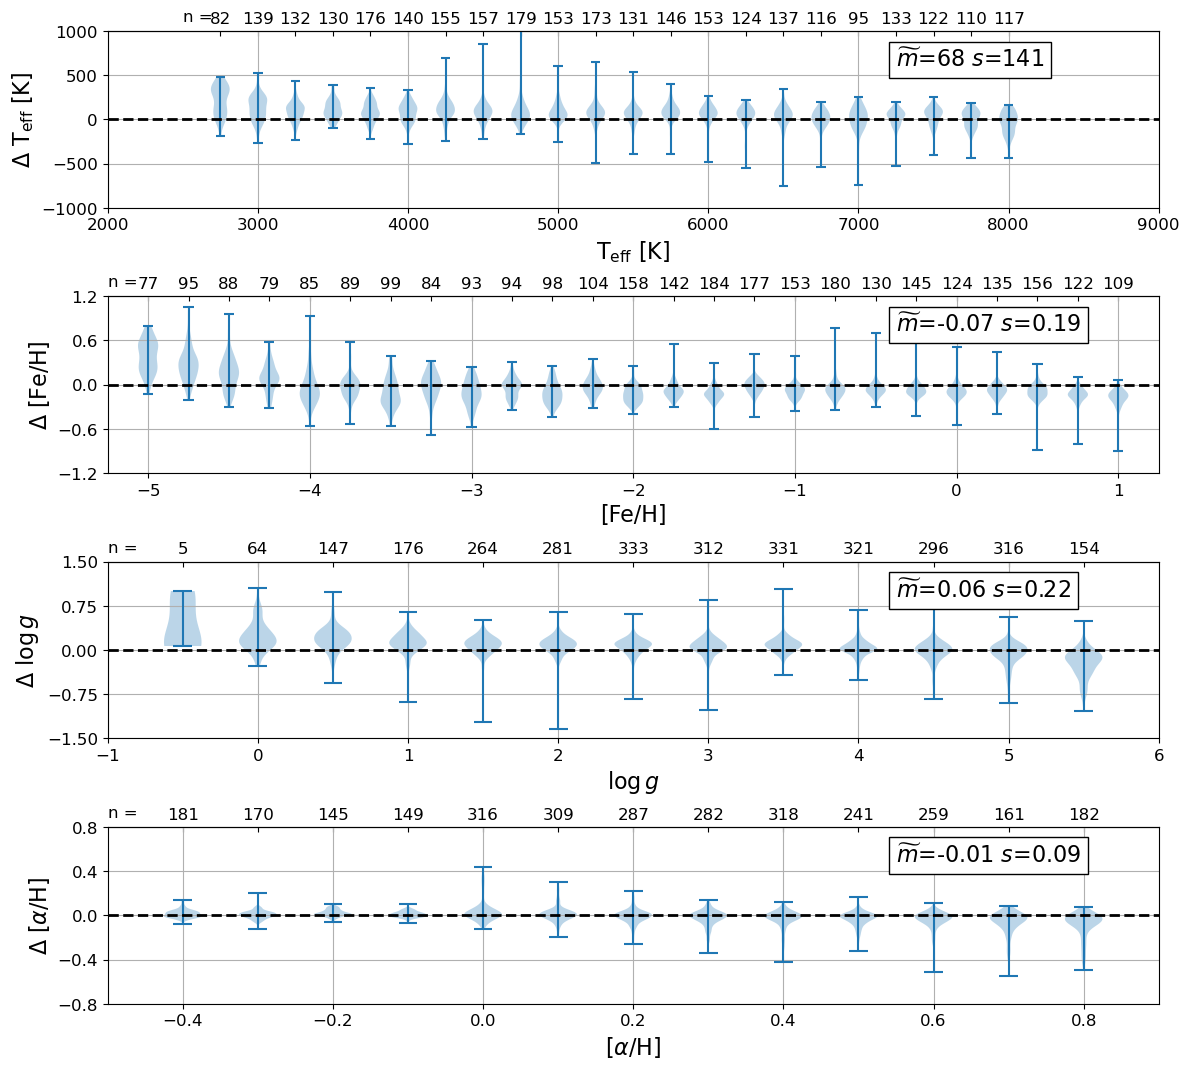

In [12]:
plot_resid_violinplot(label_keys, tgt_labels, pred_labels, 
                      y_lims=[1000, 1.2, 1.5, 0.8], savename=None)

I'm sure if we trained for longer or made some architecture changes, we could improve these results, but you get the idea!

## Evaluate on observations

The issue often arises when we take a model that is trained - through supervised - on synthetic data and apply it on observed data. Let's see what happens when we try that.

In [13]:
# Observed validation data

obs_data_file = os.path.join(data_dir, 'gaia_observed.h5')

obs_val_dataset = SpectraDatasetSimple(obs_data_file, 
                                       dataset='val', 
                                       label_keys=['teff', 'feh', 'logg', 'alpha'])

obs_val_dataloader = torch.utils.data.DataLoader(obs_val_dataset,
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=1,
                                                   pin_memory=True)

In [14]:
# Set parameters to not trainable
model.eval()

# Estimate labels of the validation spectra
gaia_labels = []
pred_labels = []
with torch.no_grad():
    for val_batch in obs_val_dataloader:
        
        # Switch to GPU if available
        val_batch = batch_to_device(val_batch, device)

        # Forward propagation (and denormalize outputs)
        label_preds = model(val_batch['spectrum'], 
                            norm_in=True, 
                            denorm_out=True)
        
        # Save batch data for comparisons
        pred_labels.append(label_preds.cpu().data.numpy())
        gaia_labels.append(val_batch['labels'].cpu().data.numpy())
        
pred_labels = np.concatenate(pred_labels)
gaia_labels = np.concatenate(gaia_labels)

Now we can compare against the GAIA estimates. However, the GAIA estimates are not on a grid, so we can no longer use a box plot to show the residuals. Instead, we will just use a scatter plot.

In [15]:
def plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels,
               x_label='',
              y_lims = [1000, 1, 1, 1, 10], savename=None):
    fig, axes = plt.subplots(len(label_keys), 1, figsize=(10, len(label_keys)*2.5))

    #if not hasattr(axes, 'len'):
    #    axes = [axes]

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
    for i, ax in enumerate(axes):
        label_key = label_keys[i]
        # Make label pretty
        if label_key=='teff':
            label_key = 'T$_{\mathrm{eff}}$ [K]'
        if label_key=='feh':
            label_key = '[Fe/H]'
        if label_key=='logg':
            label_key = '$\log{g}$'
        if label_key=='alpha':
            label_key = r'[$\alpha$/H]'
        if label_key=='vrad':
            label_key = r'$v_{\mathrm{rad}}$ [km/s]'
            
        # Calculate residual
        diff = pred_stellar_labels[:,i] - tgt_stellar_labels[:,i]
        
        ax.scatter(tgt_stellar_labels[:,i], 
                    pred_stellar_labels[:,i] - tgt_stellar_labels[:,i], 
                    alpha=0.5, s=5, zorder=1, c='maroon')
        if 'eff' in label_key:
            ax.annotate('$\widetilde{m}$=%0.0f $s$=%0.0f'% (np.mean(diff), np.std(diff)),
                        (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                        bbox=bbox_props)
        elif 'rad' in label_key:
            ax.annotate('$\widetilde{m}$=%0.1f $s$=%0.1f'% (np.mean(diff), np.std(diff)),
                        (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                        bbox=bbox_props)
        else:
            ax.annotate('$\widetilde{m}$=%0.2f $s$=%0.2f'% (np.mean(diff), np.std(diff)),
                    (0.75,0.8), size=4*len(label_keys), xycoords='axes fraction', 
                    bbox=bbox_props)
        ax.set_xlabel('%s %s' % (x_label, label_key), size=4*len(label_keys))
        ax.set_ylabel(r'$\Delta$ %s' % label_key, size=4*len(label_keys))
        ax.axhline(0, linewidth=2, c='black', linestyle='--')
        ax.set_ylim(-y_lims[i], y_lims[i])
        ax.set_yticks([-y_lims[i], -0.5*y_lims[i], 0, 0.5*y_lims[i], y_lims[i]])

        ax.tick_params(labelsize=2.8*len(label_keys))
        ax.grid()
    
    plt.tight_layout()
        
    if savename is not None:
        plt.savefig(savename, facecolor='white', transparent=False, dpi=100,
                    bbox_inches='tight', pad_inches=0.05)
    
    plt.show()

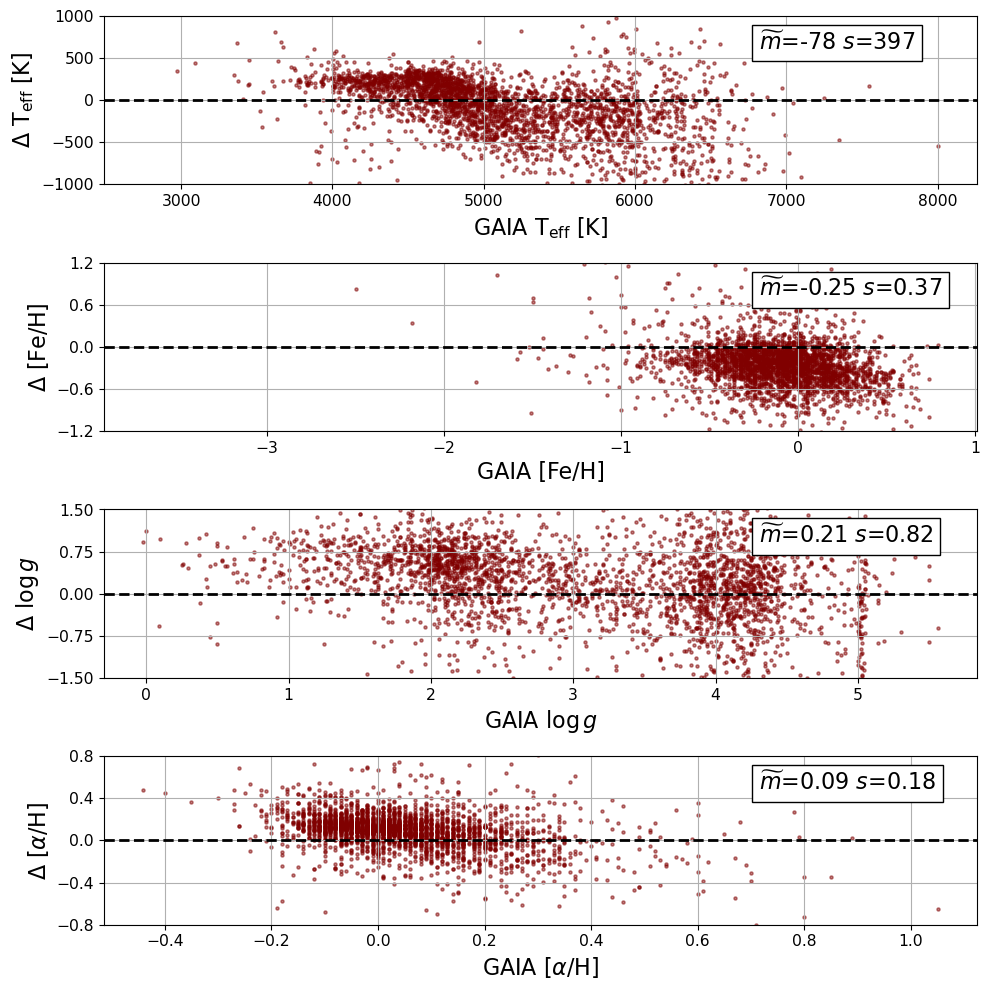

In [16]:
plot_resid(label_keys, gaia_labels, pred_labels,
               y_lims = [1000, 1.2, 1.5, 0.8], x_label='GAIA')

Honestly, this is trending better than I expected, but it still needs some improvement!